In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from ipywidgets import FloatProgress
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features

import os
from collections import defaultdict
import json
import pg8000
import h5py

1. import json files so we can get cell level qc data
2. look at 2015 and then 2016 pass/fails and add annotations for move, new hires, personal changes, increased mice, pilots, project milestones
3. change histos to heatmaps
4. improve data vis
5. check slice on rig to last known time

1. import json metadata
2. add qc results (need json path)
3. add cell level qc gates
4. convert time to useable format?

In [3]:
def get_spec_name(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        #print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%ephys_features.json'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        #print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],SplitLinux[5],''))

def get_h5(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        #print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%.h5'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        #print "Could not find h5 file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()

In [4]:
def get_times_and_voltages(json_path, h5_path):
    key_path = "MIES/LabNoteBook/ITC18USB/Device0/TextDocKeyWave"
    data_path = "MIES/LabNoteBook/ITC18USB/Device0/textDocumentation/txtDocWave"
    d_1904 = datetime.strptime("1904-01-01", "%Y-%m-%d")


    with h5py.File(h5_path) as f:
        f = h5py.File(h5_path)
        set_keys = f[key_path].get("txtDocKeyWave")[0]
        set_vals = f[data_path]

    ts_idx = np.where(set_keys == "TimeStamp")[0][0]
    name_idx =  np.where(set_keys == "Stim Wave Name")[0][0]
    num_idx = np.where(set_keys == 'Sweep #')[0][0]
    sw_names = [set_vals[entry, name_idx, 0] for entry in range(set_vals.shape[0])]
    ts_nums = [set_vals[entry, ts_idx, 0] for entry in range(set_vals.shape[0])]
    sw_nums = [set_vals[entry, num_idx, 0] for entry in range(set_vals.shape[0])]

    times = [];
    sweeps = [];
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("EXTPBREAKN"):
                #print ts
                times.append((d_1904 + timedelta(seconds=float(ts))))
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("C1RP25PR"):
                #print ts
                times.append((d_1904 + timedelta(seconds=float(ts))))
                sweeps.append(sw_nums[i])
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("C1SSCOARSE"):
                #print ts
                times.append((d_1904 + timedelta(seconds=float(ts))))
                sweeps.append(sw_nums[i])


    with open(json_path, 'r') as f:
        data = json.load(f)

    #get dictionary of actual sweep numbers
    sweep_numbers = {data['specimens'][0]['ephys_sweeps'][i]['sweep_number']:i for i in range(len(data['specimens'][0]['ephys_sweeps']))}

    times = times[:5]
    sweeps = sweeps[:4]
    voltages = []
    
    for i in sweeps:
        shortened = data['specimens'][0]['ephys_sweeps'][sweep_numbers[int(i)]]['pre_vm_mv']
        voltages.append(shortened)
    breakin_v = data['specimens'][0]['cell_ephys_features']['long_squares']['v_baseline']
    
    return times, sweeps, breakin_v, voltages

In [5]:
#if don't want to rebuild dataframe
#last created with Json from 3/2/17 on 3/8/17
df = pd.read_pickle('json_and_qc.pkl')

In [219]:
#load the JSON metadata csv as a df
#df = pd.read_csv('JSON-metadata.csv')
could_not_find = []
df = df_2

#change the NaN to 0 in all time columns
df['Approach Time'].fillna(0)
df['End/Abort Time'].fillna(0)
df['Slice on Rig Time'].fillna(0)

#cr = pd.read_csv('custom_report.csv')
new_columns = ['qc_state','seal','json_path','access_res','access_ratio','blowout','Cre line', 
               'mouse', 'date_formatted', 'failure', 'h5_path','times','sweeps','voltages','breakin_v']

for i in new_columns:
    df[i] = None
g = FloatProgress(min=0, max=len(df))
display(g)
for i,time in enumerate(df['Approach Time']):
    #fix the bad human labels
    if df['Slice Name'].iloc[i][:3] == 'H17' or df['Slice Name'].iloc[i][:3] == 'H16':
        df['Cre Status'].iloc[i] = 'human'
        df['Cre line'].iloc[i] = 'human'
        
    #under 4% of the examples don't have an approach and/or end time
    if type(time) == str:
        df['Approach Time'].iloc[i] = datetime.strptime(time[:-3],"%H:%M")
    if type(df['End/Abort Time'].iloc[i]) == str:
        df['End/Abort Time'].iloc[i] = datetime.strptime(df['End/Abort Time'].iloc[i][:-3],"%H:%M")
    if type(df['Slice on Rig Time'].iloc[i]) == str:
        df['Slice on Rig Time'].iloc[i] = datetime.strptime(df['Slice on Rig Time'].iloc[i],"%H:%M")
    if df['Outcome'].iloc[i] == 'SUCCESS':
        if df['Cre Status'].iloc[i] == 'human':
            df['json_path'].iloc[i] = get_spec_name(df['Specimen Name'].iloc[i])
        else:
            df['json_path'].iloc[i] = get_spec_name(df['Specimen Name'].iloc[i].split('-')[-1]) 
        if df['json_path'].iloc[i] != None:
            df['h5_path'].iloc[i] = get_h5(df['Specimen Name'].iloc[i].split('-')[-1])
            with open(df['json_path'].iloc[i], 'r') as f:
                data = json.load(f)
            df['seal'].iloc[i] = data['seal_gohm']
            df['access_res'].iloc[i] = data['initial_access_resistance_mohm']
            df['access_ratio'].iloc[i] = data['input_access_resistance_ratio']
            df['blowout'].iloc[i] = data['blowout_mv']
            df['qc_state'].iloc[i] = data['workflow_state']
            try:
                df['times'].iloc[i], df['sweeps'].iloc[i], df['breakin_v'].iloc[i], df['voltages'].iloc[i] = get_times_and_voltages(df['json_path'].iloc[i], df['h5_path'].iloc[i])
            except TypeError:
                pass
        else:
            could_not_find.append(i)
    else:
        event = df['Outcome Notes'].iloc[i]
        if type(event) == str:
            outcome = event.split(',')[0]
            if outcome == 'Pipette Broken':
                df['failure'].iloc[i] = 'Pipette Problems'
            elif outcome == 'Pipette Clogged':
                df['failure'].iloc[i] = 'Pipette Problems'
            elif outcome == 'Pipette Resistance Out of Range': 
                df['failure'].iloc[i] = 'Pipette Problems'
            elif outcome == 'Seal Failed':
                df['failure'].iloc[i] = 'Seal Problems'
            elif outcome == 'Unstable Seal':
                df['failure'].iloc[i] = 'Seal Problems'
            elif outcome == 'Breakin Failed':
                df['failure'].iloc[i] = 'Breakin Failed'
            elif outcome == 'Vrest Out of Range':
                df['failure'].iloc[i] = 'Bad Patch'
            elif outcome == 'Access Resistance Out of Range':
                df['failure'].iloc[i] = 'Bad Patch'
            elif outcome == 'EVERYTHING IS TERRIBLE':
                df['failure'].iloc[i] = 'Kitchen Sink'
    df['Cre line'].iloc[i] = df['Slice Name'].iloc[i].split('-')[0]
    df['date_formatted'].iloc[i] = datetime.strptime(str(df['Date'].iloc[i]+20000000),'%Y%m%d')
    if df['Cre Status'].iloc[i] != 'human':
        df['mouse'].iloc[i] = df['Slice Name'].iloc[i].split('.')[0]
    g.value += 1
#filter out anything before 10/5
#df.to_pickle('json_and_qc.pkl')

In [312]:
df.to_pickle('json_and_qc.pkl')

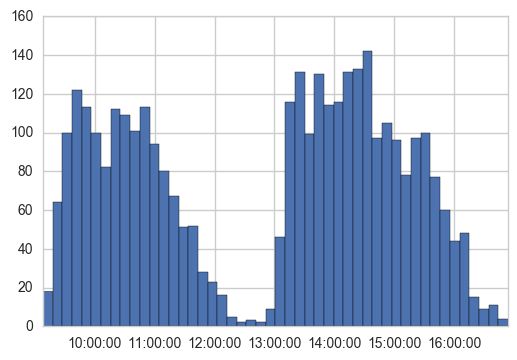

In [260]:
histo_df = df[df['Approach Time'] >=pd.Timestamp('1900-01-01 09:00:00')]
histo_df = histo_df[histo_df['Approach Time'] < pd.Timestamp('1900-01-01 17:00:00')]

ax = histo_df['Approach Time'].hist(bins = 48)
#ax.set_xticks(rotation = 'vertical')

# 1) Let's look at a heatmap of rig usage by operators

# 2) Why are cells not getting uploaded?

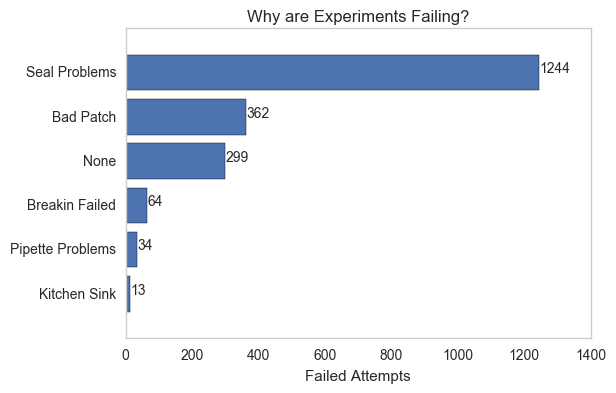

In [264]:
failure = df[(df['Outcome'] == 'FAILURE') & (df['Cre Status'] != 'human')]

categories = Counter(failure['failure'])
plt.barh(np.arange(0,len(categories)),sorted(categories.values()), align = 'center')
plt.yticks(np.arange(0,len(categories)),sorted(categories,key=categories.get))
plt.title('No Experiment loaded to LIMS')
plt.xlabel('Failed Attempts')
for i in range(len(sorted(categories.values()))):
    plt.annotate(sorted(categories.values())[i],xy = (sorted(categories.values())[i] +1, i))
plt.title('Why are Experiments Failing?')

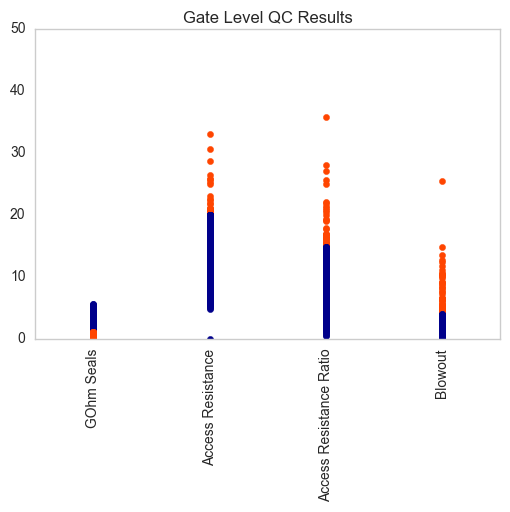

In [265]:

plt.scatter(np.ones(len(df[df['seal'] >= 1]['seal'])),df[df['seal'] >=1]['seal'],color = 'darkblue')
plt.scatter(np.ones(len(df[df['seal'] < 1]['seal'])),df[df['seal'] < 1]['seal'],color = 'orangered')

plt.scatter(np.ones(len(df[df['access_res'] >= 20]['access_res']))+1, df[df['access_res'] >= 20]['access_res'], color = 'orangered')
plt.scatter(np.ones(len(df[df['access_res'] < 20]['access_res']))+1, df[df['access_res'] < 20]['access_res'], color = 'darkblue')

plt.scatter(np.ones(len(df[df['access_ratio'] >= .15]['access_ratio']))+2, df[df['access_ratio'] >= .15]['access_ratio']*100, color = 'orangered')
plt.scatter(np.ones(len(df[df['access_ratio'] < .15]['access_ratio']))+2, df[df['access_ratio'] < .15]['access_ratio']*100, color = 'darkblue')

plt.scatter(np.ones(len(df[df['blowout'] >=4]))+3,df[df['blowout'] >=4]['blowout'], color = 'orangered')
plt.scatter(np.ones(len(df[df['blowout'] <= -4]))+3,df[df['blowout'] <= -4]['blowout'], color = 'orangered')
plt.scatter(np.ones(len(df[(df['blowout'] > -4) & (df['blowout'] < 4)]))+3,df[(df['blowout'] > -4) & (df['blowout'] < 4)]['blowout'], color = 'darkblue')

#plt.scatter(np.ones(len(df['blowout']))+3,df['blowout'])

plt.xticks(np.arange(1,5), ['GOhm Seals','Access Resistance','Access Resistance Ratio','Blowout'], rotation = 'vertical')
plt.ylim(0,50)
plt.title('Gate Level QC Results')
#'access_res','access_ratio','blowout'

(0, 1)

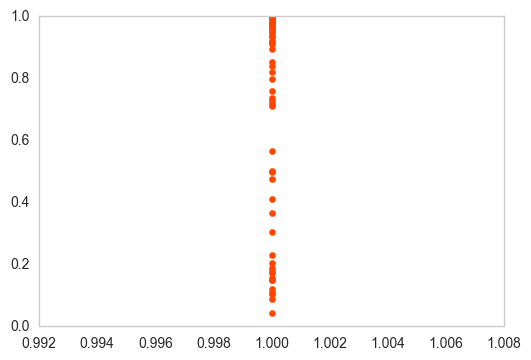

In [266]:
plt.scatter(np.ones(len(df[df['seal'] < 1]['seal'])),df[df['seal'] < 1]['seal'],color = 'orangered')
plt.ylim(0,1)

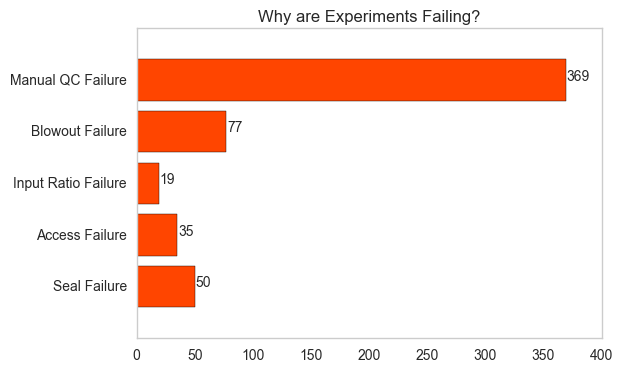

In [270]:
qc_results = []

mouse_df = df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS') & (df['qc_state'] != 'manual_passed')]

ticks = ['Seal Failure', 'Access Failure', 'Input Ratio Failure','Blowout Failure', 'Manual QC Failure']

#how many are uploaded without GOhm seal?
seal_df = mouse_df[mouse_df['seal'] < 1]
qc_results.append(len(seal_df))

#how many are uploaded with too high access?
access_df = mouse_df[(mouse_df['access_res'] >= 20) & (mouse_df['seal'] >=1)]
qc_results.append(len(access_df))

#how many are uploaded with too high access resistance ratio?
ratio_df = mouse_df[(mouse_df['access_ratio'] > .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
qc_results.append(len(ratio_df))

#how many have bad blowouts?
blowout_df = mouse_df[(mouse_df['blowout'] > 4) | (mouse_df['blowout'] < -4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
qc_results.append(len(blowout_df))


#how many then fail qc?
qc_fail = mouse_df[(mouse_df['blowout'] < 4) & (mouse_df['blowout'] >-4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
qc_results.append(len(qc_fail))

plt.barh(np.arange(0,len(qc_results)), qc_results, align = 'center', color = 'orangered')
plt.yticks(np.arange(0,len(ticks)),ticks)
for i in range(len(qc_results)):
    plt.annotate(qc_results[i],xy = (qc_results[i] +1, i))
plt.title('Why are Experiments Failing?')
#plt.xlim(0,250)

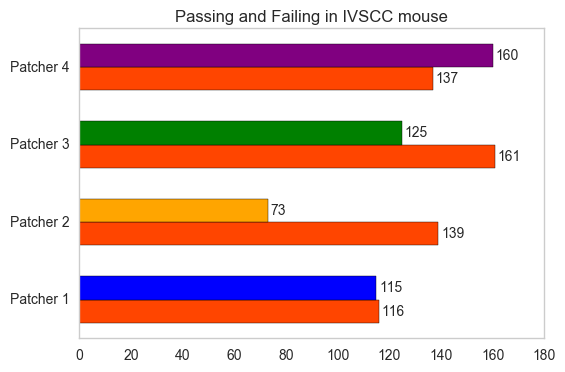

In [271]:
passing = []
failing = []

rig_ops = ['Lindsay Ng', 'DiJon Hill', 'Sam Josephsen', 'Lisa Kim']
colors = ['blue', 'orange', 'green', 'purple']

#take user names off of the axis for now
user_axis = ['Patcher 1', 'Patcher 2', 'Patcher 3', 'Patcher 4']

#look for manually passed cells and assume everything else that is uploaded to LIMS is not passed be it
#manually failed, auto-failed or still in consult

for ops in rig_ops:
    
    passing.append(len(df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS') & (df['qc_state'] == 'manual_passed') & (df['Rig Operator'] == ops)]))
    failing.append(len(df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS') & (df['qc_state'] != 'manual_passed') & (df['Rig Operator'] == ops) & (df['json_path'].notnull())]))

plt.barh(np.arange(0,len(rig_ops)),failing, height = -.3,align = 'edge',color = 'orangered')
plt.barh(np.arange(0,len(rig_ops)),passing, height = .3,align = 'edge', color = colors)
plt.yticks(np.arange(0,len(user_axis)),user_axis)

#add total number of attempts
for i in range(len(rig_ops)):
    plt.annotate(passing[i],xy=(passing[i] +1 ,i+.1))
    plt.annotate(failing[i],xy=(failing[i] +1 ,i-.2))

plt.title('Passing and Failing in IVSCC mouse')

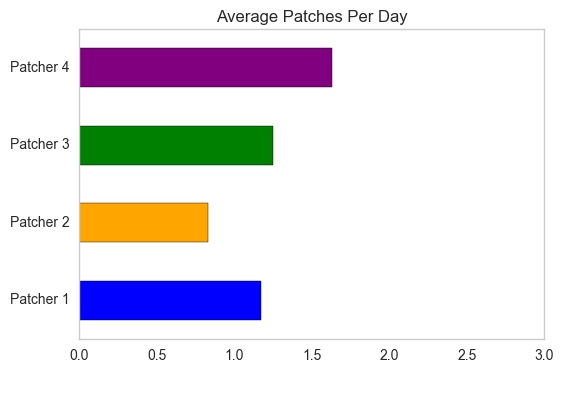

In [273]:
#cells per day

rig_ops = ['Lindsay Ng', 'DiJon Hill', 'Sam Josephsen', 'Lisa Kim']

#take user names off of the axis for now
user_axis = ['Patcher 1', 'Patcher 2', 'Patcher 3', 'Patcher 4']
colors = ['blue', 'orange', 'green', 'purple']

cpd = []

for ops in rig_ops:
    
    cells = float(len(df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS')  & (df['Rig Operator'] == ops) & (df['qc_state'] == 'manual_passed')]))
    days = float(len(np.unique(df[(df['Cre Status'] != 'human')  & (df['Rig Operator'] == ops)]['Date'])))
    cpd.append(cells/days)
    
plt.barh(np.arange(0,len(cpd)),cpd, align = 'center', height = .5,color = colors)
plt.yticks(np.arange(0,len(user_axis)),user_axis)
plt.xlim(0,3)

#add total number of attempts
for i in range(len(rig_ops)):
    plt.annotate(passing[i],xy=(passing[i] +1 ,i))
    plt.annotate(failing[i],xy=(failing[i] +1 ,i))

plt.title('Average Patches Per Day')

In [251]:
#attempts per Success
#count the patched cells
#
wins = df[df['Outcome'] == 'SUCCESS']['Slice Name']
wins = pd.DataFrame(wins, columns = ['Slice Name', 'Cells in Slice', 'Attempts']).drop_duplicates()
for i, slices in enumerate(wins['Slice Name']):
    wins['Cells in Slice'].iloc[i] = len(df[(df['Slice Name'] == slices) & (df['Outcome'] == 'SUCCESS')])
    wins['Attempts'].iloc[i] = len(df[df['Slice Name'] == slices])

In [252]:
float(sum(wins['Attempts']))/float(sum(wins['Cells in Slice']))

1.8495238095238096

([<matplotlib.axis.YTick at 0x2942e278>,
 <a list of 5 Text yticklabel objects>)

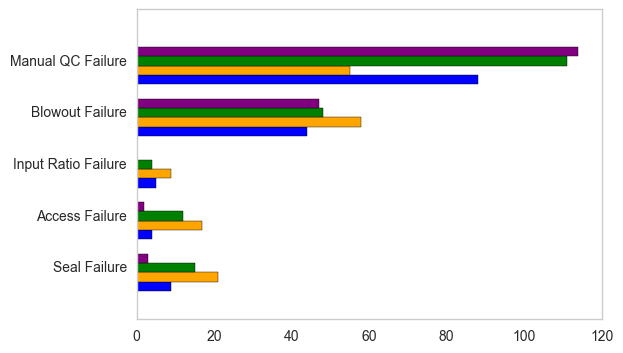

In [274]:
#failures by user

rig_ops = ['Lindsay Ng', 'DiJon Hill', 'Sam Josephsen', 'Lisa Kim']

#take user names off of the axis for now
user_axis = ['Patcher 1', 'Patcher 2', 'Patcher 3', 'Patcher 4']
colors = ['blue', 'orange', 'green', 'purple']

mouse_df = df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS') & (df['qc_state'] != 'manual_passed')]

ticks = ['Seal Failure', 'Access Failure', 'Input Ratio Failure','Blowout Failure', 'Manual QC Failure']

qc_results = np.zeros([len(rig_ops),len(ticks)])

for i, ops in enumerate(rig_ops):
    
    #how many are uploaded without GOhm seal?
    seal_df = mouse_df[(mouse_df['seal'] < 1) & (mouse_df['Rig Operator'] == ops)]
    qc_results[i,0] = len(seal_df)
    
    #how many are uploaded with too high access?
    access_df = mouse_df[(mouse_df['access_res'] >= 20) & (mouse_df['seal'] >=1) & (mouse_df['Rig Operator'] == ops)]
    qc_results[i,1] = len(access_df)

    #how many are uploaded with too high access resistance ratio?
    ratio_df = mouse_df[(mouse_df['access_ratio'] > .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1) & (mouse_df['Rig Operator'] == ops)]
    qc_results[i,2] = len(ratio_df)

    #how many have bad blowouts?
    blowout_df = mouse_df[(mouse_df['blowout'] > 4) | (mouse_df['blowout'] < -4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1) & (mouse_df['Rig Operator'] == ops)]
    qc_results[i,3] = len(blowout_df)

    #how many then fail qc?
    qc_fail = mouse_df[(mouse_df['blowout'] < 4) & (mouse_df['blowout'] >-4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1) & (mouse_df['Rig Operator'] == ops)]
    qc_results[i,4] = len(qc_fail)

    
    plt.barh(np.arange(0,len(ticks))-.36 + i*.18, qc_results[i], align = 'center', height = .18,color = colors[i])

plt.yticks(np.arange(0,len(ticks)),ticks)



In [275]:
#slices used per day
mouse_df = df[df['Cre Status'] != 'human']
days = pd.DataFrame(mouse_df, columns = ['Date', 'Mice', 'Slices Used', 'Slices Per Mouse']).drop_duplicates()
for i, day in enumerate(days['Date']):
    days['Slices Used'].iloc[i] = len(mouse_df[mouse_df['Date'] == day]['Slice Name'].drop_duplicates())
    days['Mice'].iloc[i] = np.unique(mouse_df[mouse_df['Date'] == day]['mouse'])
    days['Slices Per Mouse'].iloc[i] = days['Slices Used'].iloc[i]/len(days['Mice'].iloc[i])


In [276]:
stacked_bar = days[days['Date'] > 161003]
stacked_bar['mouse_1'] = 0
stacked_bar['mouse_2'] = 0
stacked_bar['mouse_3'] = 0
stacked_bar['mouse_4'] = 0
mouse_list = ['mouse_1','mouse_2','mouse_3','mouse_4']
stacked_bar['Dated'] = None

for i, mice in enumerate(stacked_bar['Mice']):
    stacked_bar['Dated'].iloc[i] = datetime.strptime(str(stacked_bar['Date'].iloc[i]+20000000),"%Y%m%d")
    for j, mouse in enumerate(mice):
        stacked_bar[mouse_list[j]].iloc[i] = len(mouse_df[mouse_df['mouse'] == mouse]['Slice Name'].drop_duplicates())
        
stacked_bar.reset_index()

,index,Date,Mice,Slices Used,Slices Per Mouse,mouse_1,mouse_2,mouse_3,mouse_4,Dated
0,791,161101,"[Chrna2-Cre_OE25;Ai14(BT)-279955, Chrna2-Cre_O...",10.0,3.333333,2,5,3,0,2016-11-01 00:00:00
1,807,161102,"[Chrna2-Cre_OE25;Ai14(BT)-280154, Htr3a-Cre_NO...",11.0,5.500000,5,6,0,0,2016-11-02 00:00:00
2,838,161103,"[Chrna2-Cre_OE25;Ai14(BT)-279957, Ndnf-IRES2-d...",10.0,3.333333,4,4,2,0,2016-11-03 00:00:00
3,856,161104,"[Chrna2-Cre_OE25;Ai14(BT)-281475, Gad2-IRES-Cr...",8.0,4.000000,5,3,0,0,2016-11-04 00:00:00
4,872,161107,"[Chat-IRES-Cre-neo;Ai14-280701, Ndnf-IRES2-dgC...",8.0,2.666667,1,4,3,0,2016-11-07 00:00:00
5,894,161108,"[Chat-IRES-Cre-neo;Ai14-280700, Ndnf-IRES2-dgC...",15.0,5.000000,5,6,4,0,2016-11-08 00:00:00
6,929,161109,"[Chat-IRES-Cre-neo;Ai14-280699, Ndnf-IRES2-dgC...",11.0,3.666667,2,4,5,0,2016-11-09 00:00:00
7,955,161110,"[Chat-IRES-Cre-neo;Ai14-280698, Ndnf-IRES2-dgC...",8.0,2.666667,2,3,3,0,2016-11-10 00:00:00
8,972,161111,"[Chat-IRES-Cre-neo;Ai14-280697, Sim1-Cre_KJ18;...",7.0,3.500000,1,6,0,0,2016-11-11 00:00:00
9,989,161114,"[Ctgf-2A-dgCre;Ai14(IVSCC)-280857, Ndnf-IRES2-...",17.0,5.666667,6,7,4,0,2016-11-14 00:00:00


In [277]:
#average slice health will be the average of all slices for each mouse. If slice has multiple entires they will be averaged
#range will be marke as well
stacked_bar['mouse1_avg'] = None
stacked_bar['mouse2_avg'] = None
stacked_bar['mouse3_avg'] = None
stacked_bar['mouse4_avg'] = None
stacked_bar['mouse1_rng'] = None
stacked_bar['mouse2_rng'] = None
stacked_bar['mouse3_rng'] = None
stacked_bar['mouse4_rng'] = None

mouse_avg = ['mouse1_avg','mouse2_avg','mouse3_avg','mouse4_avg']
mouse_rng = ['mouse1_rng','mouse2_rng','mouse3_rng','mouse4_rng']

for i, mice in enumerate(stacked_bar['Mice']):
    for j, mouse in enumerate(mice):
        try:
            slices = np.unique(mouse_df[mouse_df['mouse'] == mouse]['Slice Name'])
            avg = np.mean([np.mean(mouse_df[mouse_df['Slice Name'] == f]['Slice Health']) for f in slices])
            stacked_bar[mouse_avg[j]].iloc[i] = avg
            stacked_bar[mouse_rng[j]].iloc[i] = [np.min(mouse_df[mouse_df['mouse'] == mouse]['Slice Health']),np.max(mouse_df[mouse_df['mouse'] == mouse]['Slice Health'])]
        except TypeError:
            pass

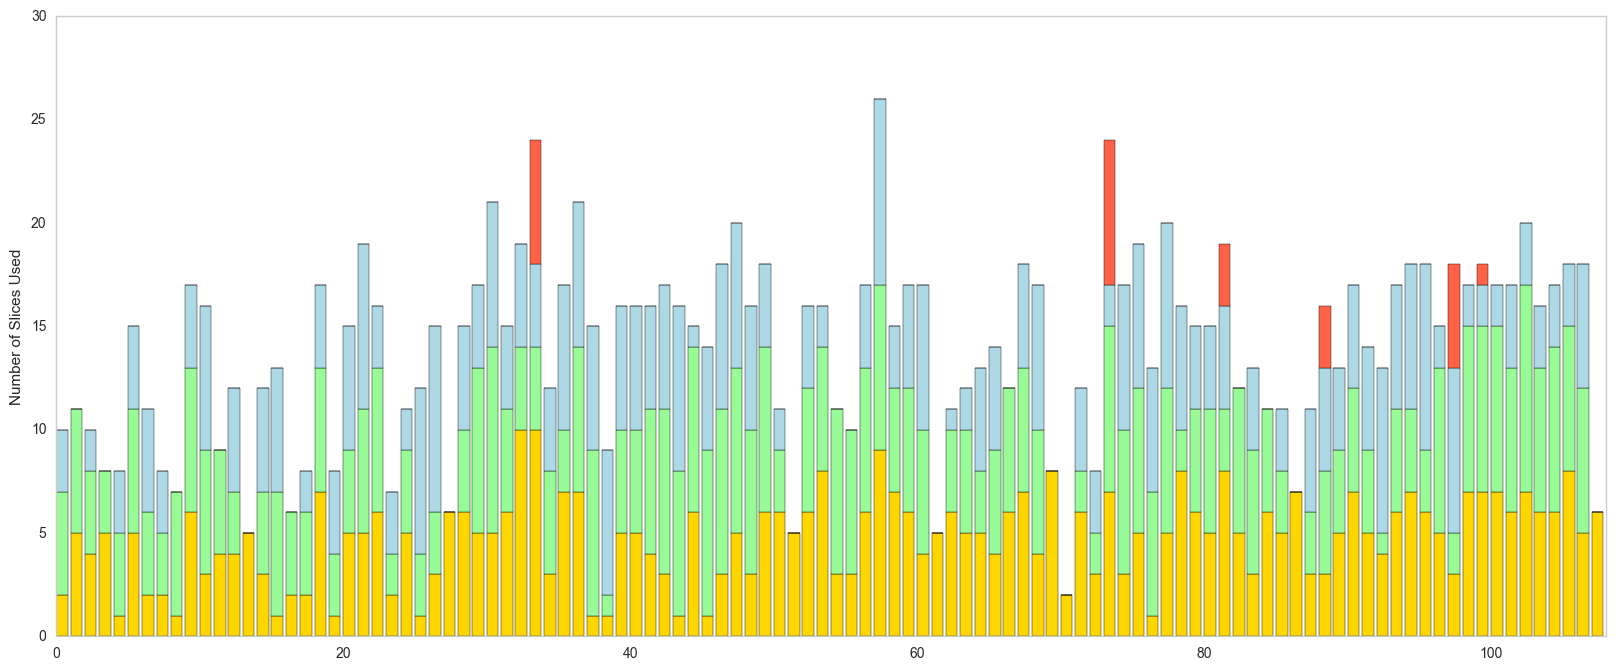

In [278]:
## p0 = plt.plot_date(stacked_bar['Date'],np.zeros(len(stacked_bar)), alpha = 0)
plt.figure(figsize = (20,8))
p1 = plt.bar(np.arange(0,len(stacked_bar)),stacked_bar['mouse_1'], color = 'gold')
p2 = plt.bar(np.arange(0,len(stacked_bar)),stacked_bar['mouse_2'], color = 'palegreen', bottom = stacked_bar['mouse_1'])
p3 = plt.bar(np.arange(0,len(stacked_bar)),stacked_bar['mouse_3'], color = 'lightblue', 
             bottom = stacked_bar['mouse_1'] + stacked_bar['mouse_2'])
p4 = plt.bar(np.arange(0,len(stacked_bar)),stacked_bar['mouse_4'], color = 'tomato', 
             bottom = stacked_bar['mouse_1'] + stacked_bar['mouse_2'] + stacked_bar['mouse_3'])

plt.xlim(0,len(stacked_bar))
plt.ylabel('Number of Slices Used')
#plt.xticks(np.arange(0,len(stacked_bar),10),stacked_bar['Dated'], rotation = 'vertical')


In [291]:
stacked_bar[stacked_bar['mouse_2'] == 0]

,Date,Mice,Slices Used,Slices Per Mouse,mouse_1,mouse_2,mouse_3,mouse_4,Dated,mouse1_avg,mouse2_avg,mouse3_avg,mouse4_avg,mouse1_rng,mouse2_rng,mouse3_rng,mouse4_rng
1187,161118,[Tlx3-Cre_PL56;Ai14-281779],5.0,5.0,5,0,0,0,2016-11-18 00:00:00,3,None,None,None,"[3, 3]",None,None,None
1641,161216,[Htr3a-Cre_NO152;Ai14-286732],6.0,6.0,6,0,0,0,2016-12-16 00:00:00,3,None,None,None,"[3, 3]",None,None,None
2481,170131,[Chat-IRES-Cre-neo;Ai14-296441],5.0,5.0,5,0,0,0,2017-01-31 00:00:00,2.4,None,None,None,"[2, 3]",None,None,None
2925,170214,[Vip-IRES-Cre;Ai14-299124],5.0,5.0,5,0,0,0,2017-02-14 00:00:00,2.6,None,None,None,"[2, 3]",None,None,None
3188,170228,[Pvalb-IRES-Cre;Ai14-299810],8.0,8.0,8,0,0,0,2017-02-28 00:00:00,2.6125,None,None,None,"[1, 4]",None,None,None
3342,170301,[Pvalb-IRES-Cre;Ai14-299815],2.0,2.0,2,0,0,0,2017-03-01 00:00:00,2.75,None,None,None,"[2, 3]",None,None,None
3740,170323,[Vip-IRES-Cre;Ai14-307955],7.0,7.0,7,0,0,0,2017-03-23 00:00:00,2.78571,None,None,None,"[2, 3]",None,None,None
4411,170421,[Chrna2-Cre_OE25;Ai14(IVSCC)-312987],6.0,6.0,6,0,0,0,2017-04-21 00:00:00,3.03333,None,None,None,"[2, 4]",None,None,None


(1, 5)

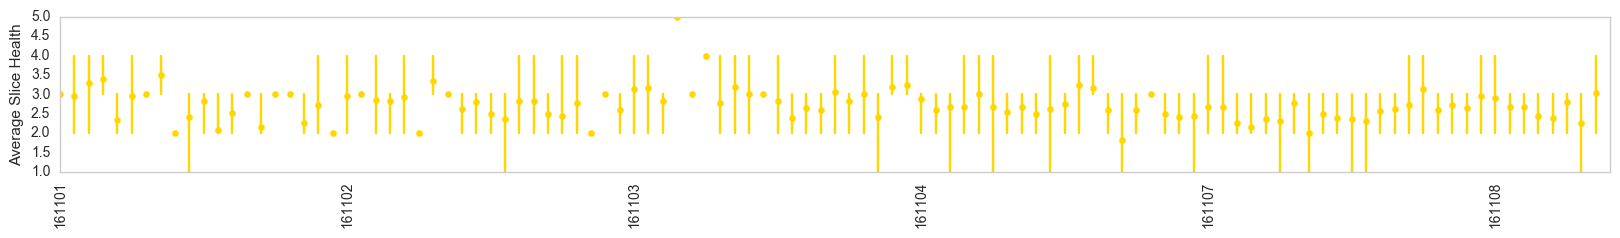

In [320]:
#stacked_bar = stacked_bar.reset_index()
plt.figure(figsize = (20,2))
for i in range(len(stacked_bar)):
    plt.scatter(i,stacked_bar['mouse1_avg'].iloc[i], color = 'gold')
    try:
        plt.plot([i,i],[stacked_bar['mouse1_rng'].iloc[i][0],stacked_bar['mouse1_rng'].iloc[i][1]], color = 'gold')
    except TypeError:
        pass
plt.xticks(np.arange(0,len(stacked_bar),20),stacked_bar['Date'], rotation = 'vertical')
plt.xlim(0,len(stacked_bar))
plt.ylabel('Average Slice Health')
plt.ylim(1,5)

In [153]:
for i in stacked_bar[stacked_bar['mouse4_avg'].notnull()]['Mice']:
    print i

['Gad2-IRES-Cre;Ai14-276111' 'Rbp4-Cre_KL100;Ai14-276123'
 'Rbp4-Cre_KL100;Ai14-276129' 'Tlx3-Cre_PL56;Ai14-275638']
['Chrna2-Cre_OE25;Ai14(IVSCC)-290476' 'Esr2-IRES2-Cre;Ai14-291921'
 'Vip-IRES-Cre;Ai14-290643' 'Vip-IRES-Cre;Ai14-290646']
['\tNkx2-1-CreERT2;Ai14(IVSCC)-291491' 'Chat-IRES-Cre-neo;Ai14-292720'
 'Nkx2-1-CreERT2;Ai14(IVSCC)-291491' 'Tlx3-Cre_PL56;Ai14-290602']


In [239]:
#cells per mouse by line
#with cells per mouse average
#mouse_df = df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS')] 

for i, cell in enumerate(mouse_df['Specimen Name']):
    mouse_df['mouse'].iloc[i] = cell.split('.')[-4]
    


NameError: name 'mouse_df' is not defined

In [280]:
cre_lines = ['Chat', 'Gad2', 'Htr3a', 'Ndnf', 'Nkx2','Nos1','Pvalb','Sst','Vip',
             'Ctgf', 'Esr2', 'Nr5a1', 'Ntsr1', 'Rbp4', 'Scnn1a', 'Sim1','Tlx3', 
             'Chrna2', 'Oxtr']
cre_colors = ['slateblue', 'slateblue', 'slateblue', 'slateblue', 'slateblue','slateblue','slateblue','slateblue','slateblue',
             'tomato', 'tomato', 'tomato', 'tomato', 'tomato', 'tomato', 'tomato','tomato', 
             'lime', 'lime']

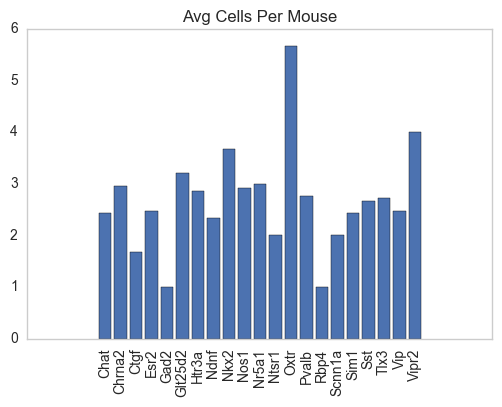

In [321]:
#cre_lines = np.unique(mouse_df['Cre line'])
cpm = np.zeros(len(cre_lines))
for i, line in enumerate(cre_lines):
    cpm[i] = len(np.unique(mouse_df[mouse_df['Cre line'] == line]['Specimen Name']))/float(len(np.unique(mouse_df[mouse_df['Cre line'] == line]['mouse'])))
#plt.bar(np.arange(0,len(cre_lines)), cpm, align = 'center', color = cre_colors)
plt.bar(np.arange(0,len(cre_lines)), cpm, align = 'center')

plt.xticks(np.arange(0,len(cre_lines)), cre_lines, rotation = 'vertical')
plt.title('Avg Cells Per Mouse')

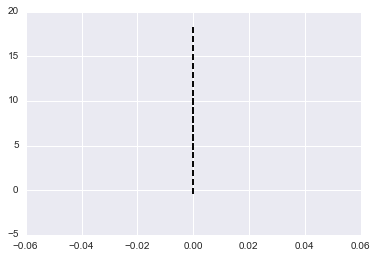

In [163]:
#cells per use per creline

rig_ops = ['Lindsay Ng', 'DiJon Hill', 'Sam Josephsen', 'Lisa Kim']

#take user names off of the axis for now
user_axis = ['Patcher 1', 'Patcher 2', 'Patcher 3', 'Patcher 4']
colors = ['blue', 'orange', 'green', 'purple']

mouse_df = df[(df['Cre Status'] == 'Cre+') & (df['Outcome'] == 'SUCCESS')]
mouse_df['Cre line'] = None

    
#cre_lines = np.unique(mouse_df['Cre line'])
results  = np.zeros([len(rig_ops),len(cre_lines)])

for j, op in enumerate(rig_ops):
    for i, cre in enumerate(cre_lines):
        results[j,i] = len(mouse_df[(mouse_df['Rig Operator'] == op) & (mouse_df['Cre line'] == cre)])
        plt.barh(np.arange(0,len(cre_lines))-.36 + j*.18, results[j], align = 'center', height = .18,color = colors[j])

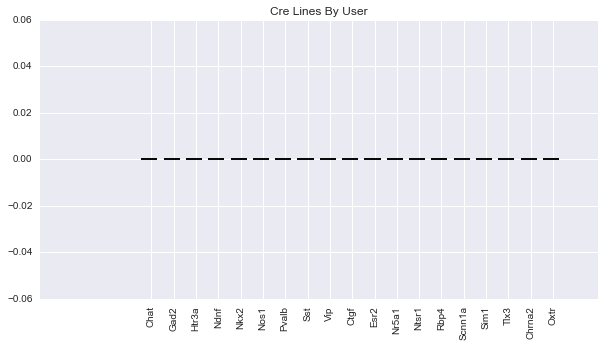

In [164]:
plt.figure(figsize = (10,5))

for j, op in enumerate(rig_ops):
    for i, cre in enumerate(cre_lines):
        results[j,i] = len(mouse_df[(mouse_df['Rig Operator'] == op) & (mouse_df['Cre line'] == cre)])
        plt.bar(np.arange(0,len(cre_lines))-.36 + j*.18, results[j], align = 'center', width = .18,color = colors[j])
#plt.figure(figsize = (5,10))
plt.xticks(np.arange(0,len(cre_lines)),cre_lines, rotation = 'vertical')
plt.title('Cre Lines By User')

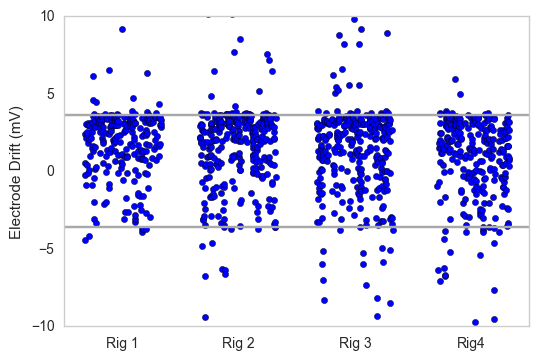

In [282]:
#blowouts by rig
blowout = df[df['blowout'].notnull()]

#arrange the xaxis by time
x0 = np.arange(0,len(blowout['Date']),dtype = float)/len(blowout['Date'])*.66-.33

plt.plot((0,5),(3.6,3.6), color = 'darkgrey')
plt.plot((0,5),(-3.6,-3.6), color = 'darkgrey')
plt.scatter(blowout['Rig #']+x0,blowout['blowout'])
plt.xlim(0.5,4.5)
plt.ylim(-10,10)
plt.xticks(np.arange(1,5),['Rig 1','Rig 2', 'Rig 3','Rig4'])
plt.ylabel('Electrode Drift (mV)')

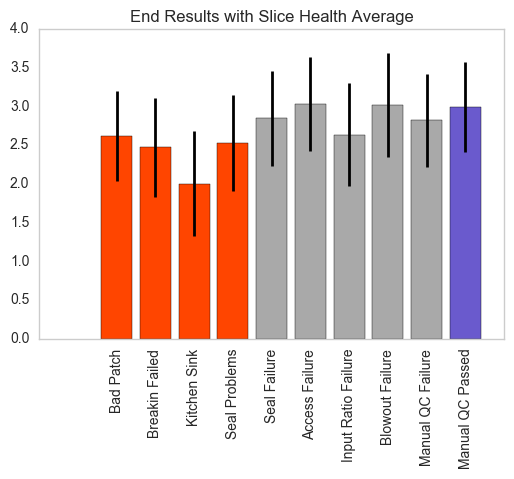

In [283]:
#cell health by failures with error bars

mouse_df = df[(df['Cre Status'] != 'human') & (df['Outcome'] == 'SUCCESS') & (df['qc_state'] != 'manual_passed')]

ticks = ['Bad Patch', 'Breakin Failed', 'Kitchen Sink','Seal Problems',
         'Seal Failure', 'Access Failure', 'Input Ratio Failure','Blowout Failure', 'Manual QC Failure', 'Manual QC Passed']
colors = [ 'orangered', 'orangered', 'orangered','orangered',
         'darkgrey', 'darkgrey', 'darkgrey','darkgrey', 'darkgrey', 'slateblue']
qc_results = np.zeros([len(ticks)])
qc_std = np.zeros([len(ticks)])

qc_results[0] = np.mean(failure[failure['failure'] == 'Bad Patch']['Slice Health'])
qc_std[0] = np.std(failure[failure['failure'] == 'Bad Patch']['Slice Health'])

qc_results[1] = np.mean(failure[failure['failure'] == 'Breakin Failed']['Slice Health'])
qc_std[1] = np.std(failure[failure['failure'] == 'Breakin Failed']['Slice Health'])

qc_results[2] = np.mean(failure[failure['failure'] == 'Kitchen Sink']['Slice Health'])
qc_std[2] = np.std(failure[failure['failure'] == 'Kitchen Sink']['Slice Health'])

qc_results[3] = np.mean(failure[failure['failure'] == 'Seal Problems']['Slice Health'])
qc_std[3] = np.std(failure[failure['failure'] == 'Seal Problems']['Slice Health'])


#how many are uploaded without GOhm seal?
seal_df = mouse_df[mouse_df['seal'] < 1]
qc_results[4] = np.mean(seal_df['Slice Health'])
qc_std[4] = np.std(seal_df['Slice Health'])

#how many are uploaded with too high access?
access_df = mouse_df[(mouse_df['access_res'] >= 20) & (mouse_df['seal'] >=1)]
qc_results[5] = np.mean(access_df['Slice Health'])
qc_std[5] = np.std(access_df['Slice Health'])

#how many are uploaded with too high access resistance ratio?
ratio_df = mouse_df[(mouse_df['access_ratio'] > .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
qc_results[6] = np.mean(ratio_df['Slice Health'])
qc_std[6] = np.std(ratio_df['Slice Health'])

#how many have bad blowouts?
blowout_df = mouse_df[(mouse_df['blowout'] > 4) | (mouse_df['blowout'] < -4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
#still needs some work, but gets the point accross
qc_results[7] = np.mean(blowout_df['Slice Health'])
qc_std[7] = np.std(blowout_df['Slice Health'])

#how many then fail qc?
qc_fail = mouse_df[(mouse_df['blowout'] < 4) & (mouse_df['blowout'] >-4) & (mouse_df['access_ratio'] <= .15) & (mouse_df['access_res'] < 20) & (mouse_df['seal'] >=1)]
qc_results[8] = np.mean(qc_fail['Slice Health'])
qc_std[8] = np.std(qc_fail['Slice Health'])

qc_results[9] = np.mean(df[df['qc_state'] == 'manual_passed']['Slice Health'])
qc_std[9] = np.std(df[df['qc_state'] == 'manual_passed']['Slice Health'])

plt.bar(np.arange(0,len(qc_results)), qc_results, align = 'center', color = colors,
        yerr = qc_std, error_kw=dict(ecolor='black', lw=2))
plt.xticks(np.arange(0,len(ticks)),ticks,rotation = 'vertical')


plt.title('End Results with Slice Health Average')

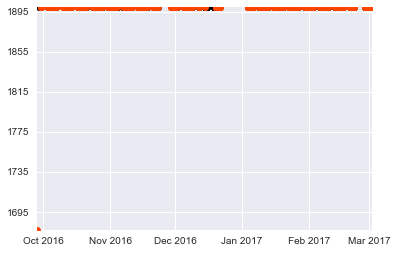

In [158]:
#success/fail per time of day
passed = df[(df['Outcome'] == 'SUCCESS') & (df['Cre Status'] != 'human')]
plt.plot_date(passed[passed['qc_state'] == 'manual_passed']['date_formatted'],passed[passed['qc_state'] == 'manual_passed']['Approach Time'], color = 'black')
plt.plot_date(passed[passed['qc_state'] != 'manual_passed']['date_formatted'],passed[passed['qc_state'] != 'manual_passed']['Approach Time'], color = 'orangered')

In [60]:
#best mouse and worse mouse

#277156 Rbp4-Cre_KL100;Ai14-277156
#278652 6 slices?
#277807 6 slices
#276831 5 slices

#276609
#276368
#277156
#281096

df[df['Slice Health'] == 1]['Slice Name']

47             Rbp4-Cre_KL100;Ai14-276129.09.06
101             Tlx3-Cre_PL56;Ai14-276366.09.06
132             Sim1-Cre_KJ18;Ai14-276204.08.06
277             Tlx3-Cre_PL56;Ai14-276369.10.06
278             Tlx3-Cre_PL56;Ai14-276369.10.06
339             Sim1-Cre_KJ18;Ai14-276609.09.06
340             Sim1-Cre_KJ18;Ai14-276609.09.06
341             Sim1-Cre_KJ18;Ai14-276609.09.06
401             Tlx3-Cre_PL56;Ai14-276368.11.06
407             Tlx3-Cre_PL56;Ai14-276368.06.06
408             Tlx3-Cre_PL56;Ai14-276368.06.06
413            Rbp4-Cre_KL100;Ai14-277156.10.06
417            Rbp4-Cre_KL100;Ai14-277156.09.06
433             Tlx3-Cre_PL56;Ai14-276368.12.06
475             Tlx3-Cre_PL56;Ai14-274368.05.06
493                Tlx3-Cre_PL56;Ai14-278652.09
799           Htr3a-Cre_NO152;Ai14-276428.03.02
981      Ctgf-2A-dgCre;Ai14(IVSCC)-280857.05.02
1085                           H16.03.011.14.13
1086                           H16.03.011.14.13
1087                           H16.03.01

## Scheduling Optimization

In [295]:
##Relationships between over mice for the day
#cre_lines = ['Tlx3','Nr5a1', 'Sim1','Chat', 'Scnn1a', 'Rbp4', 'Ntsr1', 'human',
#'Chrna2','Ctgf','Esr2','Gad2','Htr3a','Ndnf','Nkx2','Nos1','Oxtr','Pvalb','Sst','Vip','Vipr2']

cre_lines =list(np.unique(df['Cre line']))


cells_patched = np.zeros((len(cre_lines),len(cre_lines)+1))
cells_passed = np.zeros((len(cre_lines),len(cre_lines)+1))

f = FloatProgress(min=0, max=len(np.unique(df['date_formatted'])))
display(f)
for i in np.unique(df['date_formatted']):
    #gather the mice for each day
    mice = np.unique(df[(df['date_formatted'] == i)]['mouse'])
    for mouse in mice:
        if mouse is None:
            pass
        else:
            for other_mouse in mice:
                if mouse == other_mouse:
                    pass
                elif other_mouse is None:
                    idx = cre_lines.index(df[df['mouse'] == mouse]['Cre line'].iloc[0])
                    cells_patched[idx,-1] += len(df[(df['mouse']==mouse) & (df['Outcome'] == 'SUCCESS')])
                    cells_passed[idx,-1] += len(df[(df['mouse']==mouse) & (df['qc_state'] == 'manual_passed')])
                else:
                    idx = cre_lines.index(df[df['mouse'] == mouse]['Cre line'].iloc[0])
                    o_idx = cre_lines.index(df[df['mouse'] == other_mouse]['Cre line'].iloc[0])
                    cells_patched[idx,o_idx] += len(df[(df['mouse']==mouse) & (df['Outcome'] == 'SUCCESS')])
                    cells_passed[idx,o_idx] += len(df[(df['mouse']==mouse) & (df['qc_state'] == 'manual_passed')])
        f.value += 1

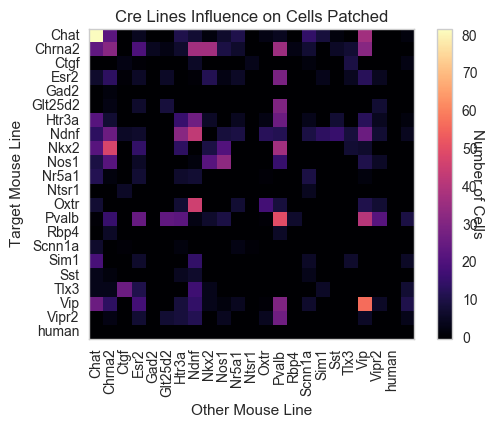

In [296]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(cells_patched, cmap='magma', interpolation = 'nearest')
cbar = plt.colorbar(plt.imshow(cells_patched, cmap='magma', interpolation = 'nearest'))
cbar.set_label('Number of Cells', rotation = 270)
plt.xticks(np.arange(0,len(cre_lines)),cre_lines,rotation = 90)
plt.yticks(np.arange(0,len(cre_lines)),cre_lines)
plt.ylabel('Target Mouse Line')
plt.xlabel('Other Mouse Line')
plt.title('Cre Lines Influence on Cells Patched')
plt.show()

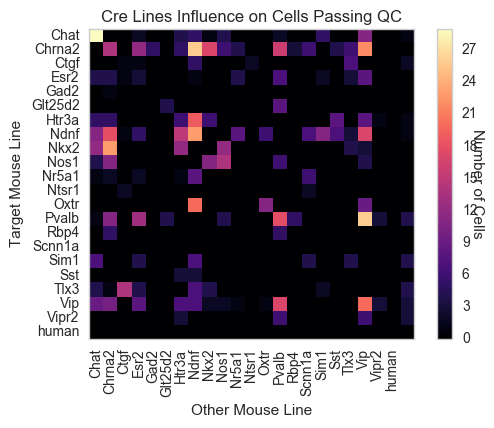

In [297]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(cells_passed, cmap='magma', interpolation = 'nearest')
cbar = plt.colorbar(plt.imshow(cells_passed, cmap='magma', interpolation = 'nearest'))
cbar.set_label('Number of Cells', rotation = 270)
plt.xticks(np.arange(0,len(cre_lines)),cre_lines,rotation = 90)
plt.yticks(np.arange(0,len(cre_lines)),cre_lines)
plt.ylabel('Target Mouse Line')
plt.xlabel('Other Mouse Line')
plt.title('Cre Lines Influence on Cells Passing QC')

plt.show()

In [303]:
#cre_lines = ['Tlx3','Nr5a1', 'Sim1','Chat', 'Scnn1a', 'Rbp4', 'Ntsr1', 'human',
#'Chrna2','Ctgf','Esr2','Gad2','Htr3a','Ndnf','Nkx2','Nos1','Oxtr','Pvalb','Sst','Vip','Vipr2']

cre_lines =list(np.unique(df['Cre line']))


days_patched = np.zeros((len(cre_lines),7))
days_passed = np.zeros((len(cre_lines),7,))

f = FloatProgress(min=0, max=len(np.unique(df['date_formatted'])))
display(f)
for i in np.unique(df['date_formatted']):
    #gather the mice for each day
    mice = np.unique(df[(df['date_formatted'] == i)]['Cre line'])
    for cre in mice:
        idx = cre_lines.index(cre)
        days_patched[idx,i.weekday()] += len(df[(df['date_formatted']==i) & (df['Outcome'] == 'SUCCESS') & (df['Cre line'] == cre)])
        days_passed[idx,i.weekday()] += len(df[(df['date_formatted']==i) & (df['qc_state'] == 'manual_passed') & (df['Cre line'] == cre)])
    f.value += 1
    
#remove the human cells since they dominate Tuesday for right now
#also remove the weekends because they are useless
days_passed = np.delete(days_passed, (21), axis=0)
days_passed = np.delete(days_passed, (6), axis=1)
days_passed = np.delete(days_passed, (5), axis=1)

days_patched = np.delete(days_patched, (21), axis=0)
days_patched = np.delete(days_patched, (6), axis=1)
days_patched = np.delete(days_patched, (5), axis=1)

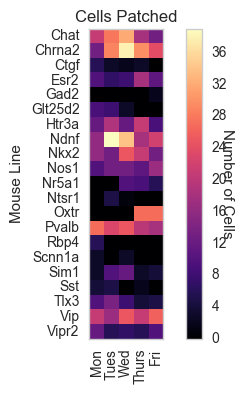

In [308]:
cre_lines =list(np.unique(df['Cre line']))
cre_lines.remove('human')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(days_patched, cmap='magma', interpolation = 'nearest')
cbar = plt.colorbar(plt.imshow(days_patched, cmap='magma', interpolation = 'nearest'))
cbar.set_label('Number of Cells', rotation = 270)
plt.xticks(np.arange(0,5),['Mon','Tues','Wed','Thurs','Fri'],rotation = 90)
plt.yticks(np.arange(0,len(cre_lines)),cre_lines)
#['Tlx3','Nr5a1', 'Sim1','Chat', 'Scnn1a', 'Rbp4', 'Ntsr1',
# 'Chrna2','Ctgf','Esr2','Gad2','Htr3a','Ndnf','Nkx2','Nos1','Oxtr','Pvalb','Sst','Vip','Vipr2']
#)
plt.ylabel('Mouse Line')
plt.title('Cells Patched')

plt.show()

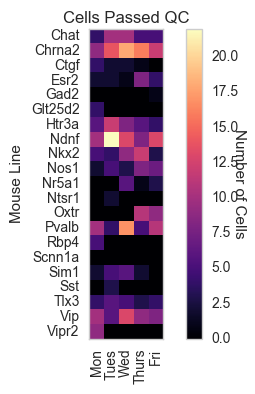

In [310]:

sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(days_passed, cmap='magma', interpolation = 'nearest')
cbar = plt.colorbar(plt.imshow(days_passed, cmap='magma', interpolation = 'nearest'))
cbar.set_label('Number of Cells', rotation = 270)
plt.xticks(np.arange(0,5),['Mon','Tues','Wed','Thurs','Fri'],rotation = 90)
plt.yticks(np.arange(0,len(cre_lines)),cre_lines)
#['Tlx3','Nr5a1', 'Sim1','Chat', 'Scnn1a', 'Rbp4', 'Ntsr1',
# 'Chrna2','Ctgf','Esr2','Gad2','Htr3a','Ndnf','Nkx2','Nos1','Oxtr','Pvalb','Sst','Vip','Vipr2']
#)
plt.ylabel('Mouse Line')
plt.title('Cells Passed QC')

plt.show()

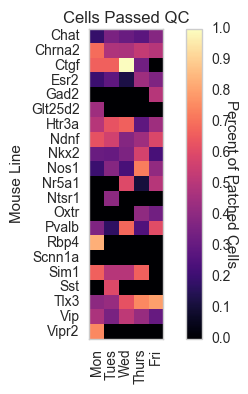

In [311]:
days_passed_norm = days_passed/days_patched
days_passed_norm[np.isnan(days_passed_norm)] = 0

sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(days_passed_norm, cmap='magma', interpolation = 'nearest')
cbar = plt.colorbar(plt.imshow(days_passed_norm, cmap='magma', interpolation = 'nearest'))
cbar.set_label('Percent of Patched Cells', rotation = 270)
plt.xticks(np.arange(0,5),['Mon','Tues','Wed','Thurs','Fri'],rotation = 90)
plt.yticks(np.arange(0,len(cre_lines)),cre_lines)
#plt.yticks(np.arange(0,len(cre_lines)-1),['Tlx3','Nr5a1', 'Sim1','Chat', 'Scnn1a', 'Rbp4', 'Ntsr1',
# 'Chrna2','Ctgf','Esr2','Gad2','Htr3a','Ndnf','Nkx2','Nos1','Oxtr','Pvalb','Sst','Vip','Vipr2']
#)
plt.ylabel('Mouse Line')
plt.title('Cells Passed QC')

plt.show()

In [293]:
for i in range(len(df)):
    if df['Cre Status'].iloc[i] == 'human':
        df['Cre line'].iloc[i] = 'human' 

ValueError: object too deep for desired array

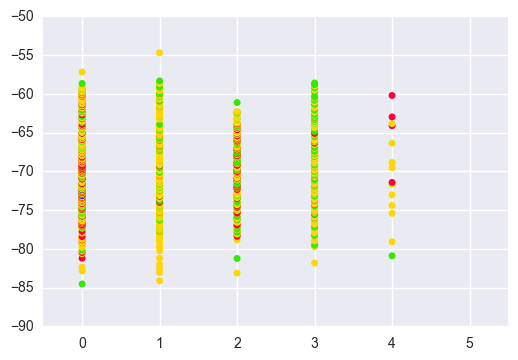

In [14]:
sns.swarmplot(x='Rig Operator', y= 'breakin_v', 
              data = df, hue = 'Slice Health',
             palette = 'prism')

In [6]:
df.columns

Index([u'ACSF Date', u'Approach Time', u'BFI Witness', u'Bad Sweeps',
       u'Cre Status', u'Date', u'End/Abort Time', u'Extra Notes', u'Flipped',
       u'Outcome', u'Outcome Notes', u'Pipette Number', u'Rig #',
       u'Rig Operator', u'Slice Health', u'Slice Name', u'Slice Notes',
       u'Slice on Rig Time', u'Specimen Name', u'qc_state', u'seal',
       u'json_path', u'access_res', u'access_ratio', u'blowout', u'Cre line',
       u'mouse', u'date_formatted', u'failure', u'h5_path', u'times',
       u'sweeps', u'voltages', u'breakin_v'],
      dtype='object')

In [13]:
df['Cre line'].nunique()

22